# Chapter 9: Evolutionary Computing（進化的計算）

このノートブックは [Nature of Code](https://natureofcode.com/genetic-algorithms/) の第9章をJuliaで実装したものです。

## 概要

遺伝的アルゴリズム（GA）は、生物の進化を模倣した最適化手法です。
ダーウィンの自然選択に基づく3つの原則を使用します：

1. **遺伝（Heredity）**: 親の特性が子に受け継がれる
2. **変異（Variation）**: 個体間に多様性が存在する
3. **選択（Selection）**: 適応度の高い個体が生き残りやすい

In [1]:
using Random
using LinearAlgebra
using Statistics
using Plots

## 9.1 遺伝的アルゴリズムの基本構造

### アルゴリズムの流れ

1. **初期化**: ランダムなDNAを持つN個の個体を生成
2. **適応度計算**: 各個体の適応度（fitness）を評価
3. **選択**: 適応度に基づいて親を選ぶ（ルーレット選択）
4. **交叉（Crossover）**: 親のDNAを組み合わせて子を作る
5. **突然変異（Mutation）**: 一定確率でDNAを変化させる
6. **世代交代**: 新しい集団で1に戻る

## 9.2 シェイクスピア問題

「無限の猿定理」に基づく古典的な例。ランダムな文字列を
目標の文字列（例："to be or not to be"）に進化させます。

In [2]:
# DNA（遺伝子）クラス
mutable struct DNA
    genes::Vector{Char}
    fitness::Float64
end

# ランダムな文字を生成
function randomChar()
    chars = vcat(collect('a':'z'), collect('A':'Z'), [' ', '.', ',', '!', '?'])
    return rand(chars)
end

# 新しいDNAを作成
function DNA(length::Int)
    genes = [randomChar() for _ in 1:length]
    DNA(genes, 0.0)
end

# 適応度を計算（目標との一致度）
function calcFitness!(dna::DNA, target::String)
    score = 0
    for i in eachindex(dna.genes)
        if dna.genes[i] == target[i]
            score += 1
        end
    end
    # 適応度を正規化し、指数的にスケール
    dna.fitness = (score / length(target))^4
end

# 交叉
function crossover(a::DNA, b::DNA)
    child = DNA(length(a.genes))
    midpoint = rand(1:length(a.genes))
    
    for i in eachindex(child.genes)
        if i < midpoint
            child.genes[i] = a.genes[i]
        else
            child.genes[i] = b.genes[i]
        end
    end
    
    return child
end

# 突然変異
function mutate!(dna::DNA, mutationRate::Float64)
    for i in eachindex(dna.genes)
        if rand() < mutationRate
            dna.genes[i] = randomChar()
        end
    end
end

# DNAを文字列に変換
getPhrase(dna::DNA) = String(dna.genes)

getPhrase (generic function with 1 method)

In [3]:
# 集団（Population）クラス
mutable struct Population
    population::Vector{DNA}
    matingPool::Vector{DNA}
    target::String
    mutationRate::Float64
    generations::Int
    finished::Bool
    perfectScore::Float64
end

function Population(target::String, mutationRate::Float64, popSize::Int)
    population = [DNA(length(target)) for _ in 1:popSize]
    
    # 初期適応度を計算
    for dna in population
        calcFitness!(dna, target)
    end
    
    Population(population, DNA[], target, mutationRate, 0, false, 1.0)
end

# 交配プールを作成（ルーレット選択）
function naturalSelection!(pop::Population)
    empty!(pop.matingPool)
    
    maxFitness = maximum(dna.fitness for dna in pop.population)
    
    for dna in pop.population
        # 適応度に比例した数だけプールに追加
        n = Int(floor(dna.fitness / maxFitness * 100))
        for _ in 1:n
            push!(pop.matingPool, dna)
        end
    end
end

# 新世代を生成
function generate!(pop::Population)
    for i in eachindex(pop.population)
        # ランダムに2つの親を選択
        parentA = rand(pop.matingPool)
        parentB = rand(pop.matingPool)
        
        # 交叉
        child = crossover(parentA, parentB)
        
        # 突然変異
        mutate!(child, pop.mutationRate)
        
        # 適応度を計算
        calcFitness!(child, pop.target)
        
        pop.population[i] = child
    end
    
    pop.generations += 1
end

# 最も適応度の高い個体を取得
function getBest(pop::Population)
    best = pop.population[1]
    for dna in pop.population
        if dna.fitness > best.fitness
            best = dna
        end
    end
    return best
end

# 完了チェック
function evaluate!(pop::Population)
    best = getBest(pop)
    if best.fitness >= pop.perfectScore
        pop.finished = true
    end
end

evaluate! (generic function with 1 method)

In [4]:
# シェイクスピア問題を実行
function run_shakespeare(target::String; popSize=200, mutationRate=0.01, maxGen=1000)
    pop = Population(target, mutationRate, popSize)
    
    history = String[]
    fitness_history = Float64[]
    
    while !pop.finished && pop.generations < maxGen
        naturalSelection!(pop)
        generate!(pop)
        evaluate!(pop)
        
        best = getBest(pop)
        push!(history, getPhrase(best))
        push!(fitness_history, best.fitness)
        
        if pop.generations % 50 == 0 || pop.finished
            println("Gen $(pop.generations): $(getPhrase(best)) (fitness: $(round(best.fitness, digits=4)))")
        end
    end
    
    return pop, fitness_history
end

target = "to be or not to be"
pop, fitness_history = run_shakespeare(target, popSize=300, mutationRate=0.01)

Gen 50: to be !r wot to be (fitness: 0.6243)


Gen 65: to be or not to be (fitness: 1.0)


(Population(DNA[DNA(['t', 'o', ' ', 'b', 'e', ' ', 'o', 'r', ' ', 'f', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.7956199512269471), DNA(['t', 'o', ' ', 'b', 'e', 'd', '!', 'r', ' ', 'f', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.4822530864197532), DNA(['t', 'E', ' ', 'b', 'e', ' ', 'b', 'c', '?', 'n', 'o', 't', ' ', 't', 'w', ' ', 'b', 'e'], 0.27207171162932475), DNA(['t', 'o', 'p', '!', 'e', ' ', 'o', 'r', ' ', 'w', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.4822530864197532), DNA(['t', 'o', ' ', 'b', 'e', ' ', '!', 'r', '?', 'n', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.624295076969974), DNA(['t', 'o', ' ', 'b', 'e', 'd', 'o', 'o', ' ', 'f', 'o', 't', ' ', 't', 'o', 'J', 'b', 'I'], 0.27207171162932475), DNA(['t', 'o', ' ', 'b', 'e', 'd', 'R', 'r', ' ', 'f', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.4822530864197532), DNA(['t', 'o', ' ', 'b', 'e', 'd', 'o', 'r', ' ', 'f', 'o', 't', ' ', 't', 'o', ' ', 'b', 'e'], 0.624295076969974), DNA(['t', 'o', ' ', 'b', 'e', 'd', 'o', 'r', ' '

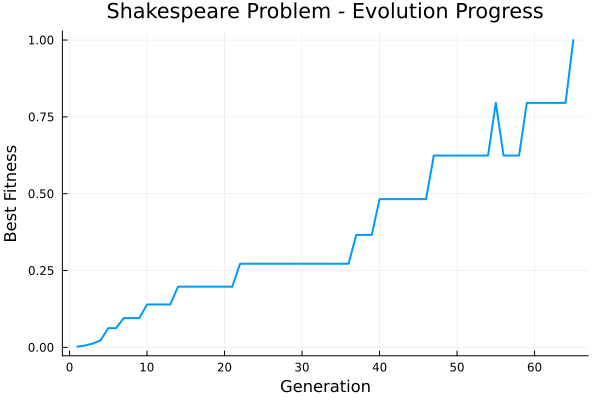

In [5]:
# 適応度の推移をプロット
plot(fitness_history, 
     xlabel="Generation", 
     ylabel="Best Fitness",
     title="Shakespeare Problem - Evolution Progress",
     legend=false,
     linewidth=2)

## 9.3 遺伝子型と表現型

- **遺伝子型（Genotype）**: 生のDNAデータ（数値配列など）
- **表現型（Phenotype）**: DNAが表現する特性（見た目、行動など）

遺伝子型をどう表現型に変換するかが、GAの設計で重要なポイントです。

## 9.4 Smart Rockets（賢いロケット）

ロケットの推進力ベクトル列を進化させて、目標に到達させます。

In [6]:
# ロケットのDNA（推進力ベクトルの配列）
mutable struct RocketDNA
    genes::Vector{Vector{Float64}}  # 各フレームの推進力
    fitness::Float64
end

function RocketDNA(lifespan::Int)
    genes = [[rand()*2-1, rand()*2-1] .* 0.1 for _ in 1:lifespan]
    RocketDNA(genes, 0.0)
end

function crossover(a::RocketDNA, b::RocketDNA)
    child = RocketDNA(length(a.genes))
    midpoint = rand(1:length(a.genes))
    
    for i in eachindex(child.genes)
        if i < midpoint
            child.genes[i] = copy(a.genes[i])
        else
            child.genes[i] = copy(b.genes[i])
        end
    end
    
    return child
end

function mutate!(dna::RocketDNA, mutationRate::Float64)
    for i in eachindex(dna.genes)
        if rand() < mutationRate
            dna.genes[i] = [rand()*2-1, rand()*2-1] .* 0.1
        end
    end
end

mutate! (generic function with 2 methods)

In [7]:
# ロケット
mutable struct Rocket
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    dna::RocketDNA
    completed::Bool
    crashed::Bool
    geneCounter::Int
    finishTime::Int
end

function Rocket(dna::RocketDNA, startPos::Vector{Float64})
    Rocket(
        copy(startPos),
        [0.0, 0.0],
        [0.0, 0.0],
        dna,
        false,
        false,
        1,
        0
    )
end

function applyForce!(r::Rocket, force::Vector{Float64})
    r.acceleration .+= force
end

function update!(r::Rocket, target::Vector{Float64}, obstacles, width, height, t)
    if r.completed || r.crashed
        return
    end
    
    # 目標との距離をチェック
    d = sqrt(sum((r.position - target).^2))
    if d < 20
        r.completed = true
        r.finishTime = t
        r.position = copy(target)
    end
    
    # 壁との衝突チェック
    if r.position[1] < 0 || r.position[1] > width ||
       r.position[2] < 0 || r.position[2] > height
        r.crashed = true
    end
    
    # 障害物との衝突チェック
    for obs in obstacles
        if obs[1] < r.position[1] < obs[1] + obs[3] &&
           obs[2] < r.position[2] < obs[2] + obs[4]
            r.crashed = true
        end
    end
    
    # DNAから力を適用
    if r.geneCounter <= length(r.dna.genes)
        applyForce!(r, r.dna.genes[r.geneCounter])
        r.geneCounter += 1
    end
    
    # 物理更新
    r.velocity .+= r.acceleration
    r.position .+= r.velocity
    r.acceleration .= 0.0
end

function calcFitness!(r::Rocket, target::Vector{Float64}, lifespan::Int)
    d = sqrt(sum((r.position - target).^2))
    r.dna.fitness = 1.0 / (d + 1)
    
    if r.completed
        r.dna.fitness *= 10
        r.dna.fitness *= (lifespan / r.finishTime)  # 早く着くほど高得点
    end
    
    if r.crashed
        r.dna.fitness *= 0.1
    end
end

calcFitness! (generic function with 2 methods)

In [8]:
# ロケットの集団
mutable struct RocketPopulation
    rockets::Vector{Rocket}
    matingPool::Vector{RocketDNA}
    target::Vector{Float64}
    obstacles::Vector{Tuple{Float64, Float64, Float64, Float64}}
    mutationRate::Float64
    lifespan::Int
    width::Float64
    height::Float64
    startPos::Vector{Float64}
    generation::Int
end

function RocketPopulation(popSize::Int, target::Vector{Float64}, 
                         obstacles, mutationRate::Float64, 
                         lifespan::Int, width::Float64, height::Float64)
    startPos = [width/2, 20.0]
    rockets = [Rocket(RocketDNA(lifespan), startPos) for _ in 1:popSize]
    
    RocketPopulation(rockets, RocketDNA[], target, obstacles, 
                     mutationRate, lifespan, width, height, startPos, 1)
end

function evaluate!(pop::RocketPopulation)
    for r in pop.rockets
        calcFitness!(r, pop.target, pop.lifespan)
    end
end

function selection!(pop::RocketPopulation)
    empty!(pop.matingPool)
    
    maxFitness = maximum(r.dna.fitness for r in pop.rockets)
    
    for r in pop.rockets
        n = Int(floor(r.dna.fitness / maxFitness * 100))
        for _ in 1:max(1, n)
            push!(pop.matingPool, r.dna)
        end
    end
end

function reproduction!(pop::RocketPopulation)
    newRockets = Rocket[]
    
    for _ in 1:length(pop.rockets)
        parentA = rand(pop.matingPool)
        parentB = rand(pop.matingPool)
        
        childDNA = crossover(parentA, parentB)
        mutate!(childDNA, pop.mutationRate)
        
        push!(newRockets, Rocket(childDNA, pop.startPos))
    end
    
    pop.rockets = newRockets
    pop.generation += 1
end

reproduction! (generic function with 1 method)

In [9]:
# シミュレーション実行
function run_rockets(;generations=50, popSize=50, lifespan=200, mutationRate=0.02)
    width, height = 400.0, 400.0
    target = [width/2, height - 30]
    
    # 障害物 (x, y, width, height)
    obstacles = [(100.0, 200.0, 200.0, 20.0)]
    
    pop = RocketPopulation(popSize, target, obstacles, mutationRate, 
                           lifespan, width, height)
    
    best_fitness = Float64[]
    success_rate = Float64[]
    
    for gen in 1:generations
        # 1世代分シミュレート
        for t in 1:lifespan
            for r in pop.rockets
                update!(r, target, obstacles, width, height, t)
            end
        end
        
        evaluate!(pop)
        
        # 統計
        maxFit = maximum(r.dna.fitness for r in pop.rockets)
        completed = count(r -> r.completed, pop.rockets)
        push!(best_fitness, maxFit)
        push!(success_rate, completed / popSize * 100)
        
        if gen % 10 == 1 || gen == generations
            println("Gen $gen: Best fitness = $(round(maxFit, digits=4)), Success rate = $(round(completed/popSize*100, digits=1))%")
        end
        
        # 次世代へ
        selection!(pop)
        reproduction!(pop)
    end
    
    return pop, best_fitness, success_rate
end

pop, best_fitness, success_rate = run_rockets(generations=30)

Gen 1: Best fitness = 0.0053, Success rate = 0.0%


Gen 11: Best fitness = 0.0056, Success rate = 0.0%
Gen 21: Best fitness = 0.0052, Success rate = 0.0%
Gen 30: Best fitness = 0.0055, Success rate = 0.0%


(RocketPopulation(Rocket[Rocket([200.0, 20.0], [0.0, 0.0], [0.0, 0.0], RocketDNA([[0.009954859666858096, -0.08789737571897352], [0.0967175297418572, 0.011778542495875712], [-0.07419731610666251, -0.03443315830095539], [-0.04715292430573941, 0.09747829679247406], [0.06579938879675151, -0.04872348469071457], [-0.04072302863887867, 0.04655784276761195], [-0.009756344770042481, -0.03772661008514016], [0.07166259044441463, 0.07077637256504472], [0.020144129219575937, 0.08132894578391321], [0.06907472761857457, -0.06840860793188823]  …  [-0.03144283755948958, 0.0022775631254233542], [-0.03800183749752195, 0.052736977255819786], [0.056403037559140515, 0.07919147723815337], [0.015466391047409857, 0.09767272220902211], [-0.09378397605246569, -0.09689874848262632], [0.03338710797943889, -0.05109578319244645], [-0.06151294434913588, -0.08908824039128593], [-0.01911121502156792, -0.0958842227092299], [-0.008302041896422986, 0.08944544202743454], [-0.09541976757360089, 0.02519756125374675]], 0.0), 

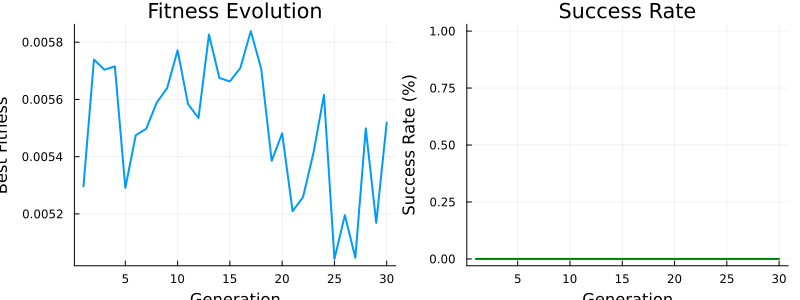

In [10]:
# 結果をプロット
p1 = plot(best_fitness, xlabel="Generation", ylabel="Best Fitness", 
          title="Fitness Evolution", legend=false, linewidth=2)
p2 = plot(success_rate, xlabel="Generation", ylabel="Success Rate (%)", 
          title="Success Rate", legend=false, linewidth=2, color=:green)

plot(p1, p2, layout=(1, 2), size=(800, 300))

## 9.5 数値最適化問題

遺伝的アルゴリズムを使って、関数の最大値/最小値を探索します。

In [11]:
# 最適化対象の関数（Rastrigin関数 - 多くの局所最小値を持つ）
function rastrigin(x::Vector{Float64})
    A = 10
    n = length(x)
    return A * n + sum(xi^2 - A * cos(2π * xi) for xi in x)
end

# 最適化用DNA
mutable struct OptDNA
    genes::Vector{Float64}
    fitness::Float64
end

function OptDNA(dim::Int, bounds::Tuple{Float64, Float64})
    genes = [bounds[1] + rand() * (bounds[2] - bounds[1]) for _ in 1:dim]
    OptDNA(genes, 0.0)
end

function calcFitness!(dna::OptDNA)
    # 最小化問題なので、値が小さいほど適応度が高い
    dna.fitness = 1.0 / (1.0 + rastrigin(dna.genes))
end

function crossover_opt(a::OptDNA, b::OptDNA)
    child = OptDNA(length(a.genes), (-5.12, 5.12))
    
    # ブレンド交叉
    for i in eachindex(child.genes)
        α = rand()
        child.genes[i] = α * a.genes[i] + (1-α) * b.genes[i]
    end
    
    return child
end

function mutate_opt!(dna::OptDNA, mutationRate::Float64, bounds::Tuple{Float64, Float64})
    for i in eachindex(dna.genes)
        if rand() < mutationRate
            # ガウシアン突然変異
            dna.genes[i] += randn() * 0.5
            dna.genes[i] = clamp(dna.genes[i], bounds[1], bounds[2])
        end
    end
end

mutate_opt! (generic function with 1 method)

In [12]:
function run_optimization(;dim=2, popSize=100, generations=100, mutationRate=0.1)
    bounds = (-5.12, 5.12)
    
    # 初期集団
    population = [OptDNA(dim, bounds) for _ in 1:popSize]
    for dna in population
        calcFitness!(dna)
    end
    
    best_values = Float64[]
    
    for gen in 1:generations
        # 選択（トーナメント選択）
        newPopulation = OptDNA[]
        
        for _ in 1:popSize
            # トーナメント選択
            tournament = rand(population, 5)
            parentA = tournament[argmax([t.fitness for t in tournament])]
            tournament = rand(population, 5)
            parentB = tournament[argmax([t.fitness for t in tournament])]
            
            child = crossover_opt(parentA, parentB)
            mutate_opt!(child, mutationRate, bounds)
            calcFitness!(child)
            
            push!(newPopulation, child)
        end
        
        population = newPopulation
        
        best = population[argmax([dna.fitness for dna in population])]
        bestValue = rastrigin(best.genes)
        push!(best_values, bestValue)
        
        if gen % 20 == 0
            println("Gen $gen: Best value = $(round(bestValue, digits=6)), genes = $(round.(best.genes, digits=3))")
        end
    end
    
    return population, best_values
end

pop_opt, best_values = run_optimization(dim=5, popSize=100, generations=200)

Gen 20: Best value = 0.005035, genes = [-0.001, -0.001, 0.002, 0.004, 0.001]


Gen 40: Best value = 0.00048, genes = [0.0, -0.001, 0.0, 0.0, -0.001]
Gen 60: Best value = 0.000488, genes = [0.0, -0.001, 0.0, 0.0, -0.001]
Gen 80: Best value = 0.000224, genes = [0.0, -0.001, 0.0, 0.0, -0.001]
Gen 100: Best value = 0.000218, genes = [0.0, -0.001, 0.0, -0.0, -0.001]
Gen 120: Best value = 9.0e-5, genes = [0.0, -0.001, 0.0, -0.0, 0.0]
Gen 140: Best value = 3.0e-6, genes = [0.0, 0.0, 0.0, -0.0, 0.0]
Gen 160: Best value = 2.0e-6, genes = [0.0, 0.0, 0.0, -0.0, 0.0]
Gen 180: Best value = 2.0e-6, genes = [0.0, 0.0, 0.0, -0.0, 0.0]
Gen 200: Best value = 2.0e-6, genes = [0.0, 0.0, 0.0, -0.0, 0.0]


(OptDNA[OptDNA([8.674414928839237e-5, 1.476460275982781e-9, 0.10685452355039701, -1.0624163767690245e-6, 1.583914578294849e-8], 0.3142853450661627), OptDNA([8.674414928839237e-5, 1.4764619606944702e-9, -0.40240271647822834, 0.13021465664350515, 1.5839145812233823e-8], 0.04440254189579663), OptDNA([8.674414928839237e-5, 1.4764552498423466e-9, 2.7254528377630068e-5, -0.006391833485540889, -0.46554797336361753], 0.04763841749394267), OptDNA([8.674414928839237e-5, -0.4442447941922425, 2.7254528363515012e-5, -1.0624163767698774e-6, 1.5839145766520365e-8], 0.04856730468406435), OptDNA([-0.1491118770438364, 1.4764668203999305e-9, 2.7254528354798152e-5, 0.09614670961057634, 1.5839145897855358e-8], 0.14538096799712114), OptDNA([-0.3337050094597609, 1.4764667597663558e-9, 2.725452824424686e-5, -1.0624163767677838e-6, 1.5839145885977785e-8], 0.06199024681574488), OptDNA([8.674414928839237e-5, 1.476463996620966e-9, 2.7254528467005213e-5, -1.062416376768509e-6, 1.58391459534134e-8], 0.9999983596005

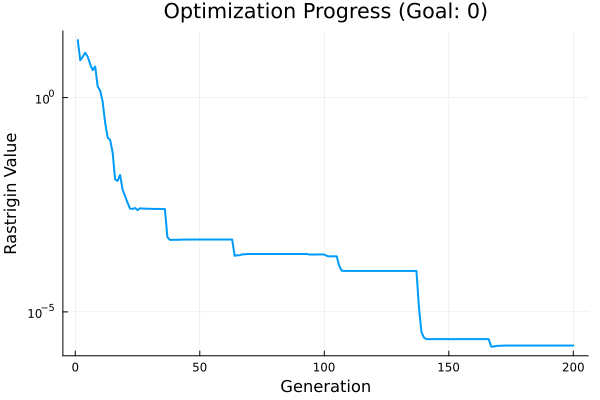

In [13]:
# 収束をプロット
plot(best_values, xlabel="Generation", ylabel="Rastrigin Value",
     title="Optimization Progress (Goal: 0)",
     legend=false, linewidth=2, yscale=:log10)

## 9.6 インタラクティブ選択

人間が適応度を決める方式。芸術作品や音楽の生成に使用されます。

例：
- 好みの色の組み合わせを進化させる
- ユーザーが「かわいい」と思うキャラクターを進化させる

## 9.7 生態系シミュレーション

捕食者と被食者の関係で、明示的な適応度関数を使わずに進化させます。
生き残って繁殖した個体が次世代を作ります。

In [14]:
# シンプルな生態系シミュレーション
mutable struct Creature
    position::Vector{Float64}
    velocity::Vector{Float64}
    dna::Vector{Float64}  # [速度, 知覚範囲, 食欲]
    health::Float64
    age::Int
end

function Creature(pos::Vector{Float64}; dna=nothing)
    if dna === nothing
        dna = [rand()*3 + 1, rand()*50 + 10, rand()*0.5 + 0.1]
    end
    Creature(pos, [0.0, 0.0], dna, 100.0, 0)
end

function reproduce(c::Creature)
    newDNA = copy(c.dna)
    # 突然変異
    for i in eachindex(newDNA)
        if rand() < 0.1
            newDNA[i] *= (0.9 + rand() * 0.2)
        end
    end
    return Creature(copy(c.position), dna=newDNA)
end

function simulate_ecosystem(;steps=500, initialPop=30)
    width, height = 400.0, 400.0
    food = [[rand()*width, rand()*height] for _ in 1:50]
    creatures = [Creature([rand()*width, rand()*height]) for _ in 1:initialPop]
    
    population_history = Int[]
    avg_speed = Float64[]
    avg_perception = Float64[]
    
    for step in 1:steps
        # 食べ物を追加
        if rand() < 0.3
            push!(food, [rand()*width, rand()*height])
        end
        
        toRemove = Int[]
        newCreatures = Creature[]
        
        for (i, c) in enumerate(creatures)
            # 最も近い食べ物を探す
            perception = c.dna[2]
            speed = c.dna[1]
            
            closestFood = nothing
            closestDist = Inf
            closestIdx = -1
            
            for (fi, f) in enumerate(food)
                d = sqrt(sum((c.position - f).^2))
                if d < perception && d < closestDist
                    closestDist = d
                    closestFood = f
                    closestIdx = fi
                end
            end
            
            # 移動
            if closestFood !== nothing
                dir = closestFood - c.position
                if norm(dir) > 0
                    c.velocity = dir / norm(dir) * speed
                end
            else
                # ランダムウォーク
                c.velocity = [rand()*2-1, rand()*2-1] * speed * 0.5
            end
            
            c.position .+= c.velocity
            
            # 境界処理
            c.position[1] = mod(c.position[1], width)
            c.position[2] = mod(c.position[2], height)
            
            # 食べ物を食べる
            if closestFood !== nothing && closestDist < 5
                c.health += 30
                deleteat!(food, closestIdx)
            end
            
            # エネルギー消費（速いほど消費大）
            c.health -= 0.5 + speed * 0.1
            c.age += 1
            
            # 繁殖
            if c.health > 150 && rand() < 0.05
                push!(newCreatures, reproduce(c))
                c.health -= 50
            end
            
            # 死亡
            if c.health <= 0
                push!(toRemove, i)
            end
        end
        
        # 死んだ個体を削除
        deleteat!(creatures, toRemove)
        append!(creatures, newCreatures)
        
        # 統計
        push!(population_history, length(creatures))
        if length(creatures) > 0
            push!(avg_speed, mean(c.dna[1] for c in creatures))
            push!(avg_perception, mean(c.dna[2] for c in creatures))
        else
            push!(avg_speed, 0)
            push!(avg_perception, 0)
        end
        
        # 絶滅チェック
        if length(creatures) == 0
            println("Extinction at step $step")
            break
        end
    end
    
    return population_history, avg_speed, avg_perception
end

pop_hist, speeds, perceptions = simulate_ecosystem(steps=1000)

([30, 30, 30, 30, 30, 30, 30, 30, 30, 30  …  14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987, 2.5025195004044987  …  3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336, 3.0074991414545336], [40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071, 40.80063797904071  …  58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605, 58.40600983959605])

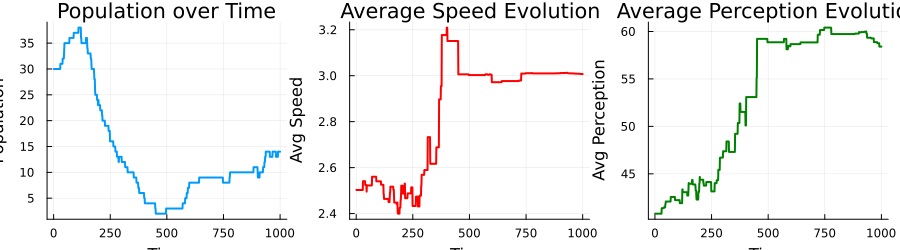

In [15]:
# 結果をプロット
p1 = plot(pop_hist, xlabel="Time", ylabel="Population", 
          title="Population over Time", legend=false, linewidth=2)
p2 = plot(speeds, xlabel="Time", ylabel="Avg Speed", 
          title="Average Speed Evolution", legend=false, linewidth=2, color=:red)
p3 = plot(perceptions, xlabel="Time", ylabel="Avg Perception", 
          title="Average Perception Evolution", legend=false, linewidth=2, color=:green)

plot(p1, p2, p3, layout=(1, 3), size=(900, 250))

## まとめ

### 遺伝的アルゴリズムの構成要素

| 要素 | 説明 |
|------|------|
| 遺伝子（Genes） | 解の表現（ビット列、実数配列など） |
| 適応度（Fitness） | 解の良さの評価 |
| 選択（Selection） | 優れた個体を親として選ぶ |
| 交叉（Crossover） | 親のDNAを組み合わせる |
| 突然変異（Mutation） | ランダムな変化を加える |

### 選択方法

- **ルーレット選択**: 適応度に比例した確率で選択
- **トーナメント選択**: ランダムに選んだ中から最良を選択
- **エリート選択**: 最良の個体を必ず次世代に残す

### パラメータ調整

- **集団サイズ**: 大きいほど多様性が高い
- **突然変異率**: 高すぎると収束しない、低すぎると局所解に陥る
- **選択圧**: 強すぎると多様性を失う

### 応用分野

- スケジューリング問題
- ニューラルネットワークの構造最適化
- ゲームAI
- アート・音楽生成
- 工学設計の最適化